In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Demand
import Solar
import Price
import Date
import Forecast

In [2]:
'''
NEW just battery
'''

'\nNEW just battery\n'

In [3]:
def predictedcharge(bigdata, daywanted):
    
    slope_intercept = pd.read_csv('Data/regression_values.csv')
    
    date = Date.getdatewanted(daywanted, 2014)
    month = Date.getmonth(date)

    slope = slope_intercept['slope'][month-1]
    intercept = slope_intercept['intercept'][month-1]

    cloud = Forecast.getcloudcover(daywanted)

    predicted_insolance = slope*cloud+intercept
    
    predictedcharge = predicted_insolance*1600*0.9
    
    daydemand = []
    for n in range(24):
        if bigdata['Total Supply (kWh)'][n] > 0:
            daydemand.append(bigdata['Total Demand (kWh)'][n])
        
    predictedcharge = predictedcharge-np.sum(daydemand)
    
    return predictedcharge

In [4]:
def chargeneeded(bigdata):

    eff = 0.9
    chargeneeded = 0
    median = np.median(bigdata['Grid Buy Price'])
    batterycharge = 0
    

    for n in range(0,24):
            
        if bigdata['Grid Buy Price'][n] >= median*1.5:
            chargeneeded = chargeneeded + bigdata['Net Demand'][n]/(eff)


    return chargeneeded


In [5]:
## method to run the SMART system ##
## if its predicted

def run_SMART(bigdata, daywanted, starting_soc):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 1120
    power = 415
    eff = 0.9
    
    median = np.median(bigdata['Grid Buy Price'])
#     required_battery_charge = chargeneeded(bigdata)
#     predicted_battery_charge = predictedcharge(bigdata, daywanted)
    
#     print(required_battery_charge, predicted_battery_charge)
    
    for n in range(0,24):
        
        if n == 0:
            soc_temp = starting_soc[daywanted-1]
        else:
            soc_temp = soc[n-1]

        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        
#         if required_battery_charge > predicted_battery_charge: 
#             if n == 5:
#                 batteryoutput[n] = max(-power, -(1/eff)*(required_battery_charge - predicted_battery_charge))
#                 soc[n] = soc_temp - batteryoutput[n]*eff
#                 continue
                
#         if n == 0:
#             use = True
#         if n == 14:
#             use = False
#         if bigdata['Grid Buy Price'][n] >= median*1.5:
#             use = True
            
        use = True
        ## the smart design ##
        ## the smart design ##
        ## the smart design ##

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)
            if use == False:
                soc[n] = soc[n-1]
                batteryoutput[n] = 0

        elif bigdata['Net Demand'][n] < 0:     # charge the battery
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp

        
    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - SMART'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - SMART'] = bigdata['Net Demand - SMART']*bigdata['Grid Buy Price']
    bigdata['Running Cost - SMART'] = bigdata['Running Cost - SMART'].clip(lower=0)
    bigdata['Running Profit - SMART'] = -bigdata['Net Demand - SMART']*bigdata['Grid Sell Price']
    bigdata['Running Profit - SMART'] = bigdata['Running Profit - SMART'].clip(lower=0)
    bigdata['soc - SMART'] = soc
    bigdata['battery output - SMART'] = batteryoutput
    
    ## adds the end day soc into the global vector to use for the next day ##
    starting_soc[daywanted] = soc[23]
    ## returns the new bigdata ##
    
    return bigdata


In [6]:
## initialises the daily cost vectors ##
SMART_cost = np.zeros(365)
SMART_profit = np.zeros(365)
_import_ = np.zeros(24*365)
_export_ = np.zeros(24*365)
solar_prediction = pd.read_csv('Data/solarprediction.csv')
# starting_soc = np.zeros(365)
starting_soc = np.zeros(366)


for n in range(0, 365):

    ## loads in the data ##
    print(n)
    daywanted = n+1
    datewanted = Date.getdatewanted(daywanted, 2014)
    totaldemand = Demand.gettotaldemand(daywanted)
    solarsupply = Solar.getsolarsupply(daywanted)
    buyprice = Price.getconstantbuyprice(daywanted)
    sellprice = Price.getconstantsellprice(daywanted)
    bigdata =pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
    bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
    bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
    bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
    bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
    bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

    ## runs the battery for that day ##
    
    bigdata = run_SMART(bigdata, daywanted, starting_soc)

    ## adds the day into the year vector ##

 
    SMART_cost[n] = bigdata['Running Cost - SMART'].sum()
    SMART_profit[n] = bigdata['Running Profit - SMART'].sum()
    
#     _import_[n] = bigdata['Net Demand - SMART'].clip(lower=0).sum()
#     temp = bigdata['Net Demand - SMART']*(-1)
#     _export_[n] = temp.clip(lower=0).sum()
    
    ## adds the day into the year vector ##

    for q in range(24):
    
        if bigdata['Net Demand - SMART'][q] < 0:
            _export_[n*24+q] = bigdata['Net Demand - SMART'][q]*-1
            
        if bigdata['Net Demand - SMART'][q] > 0:
            _import_[n*24+q] = bigdata['Net Demand - SMART'][q]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
SMART_cost.sum()

15099.095252394824

In [8]:
SMART_profit.sum()

59643.196262127945

In [9]:
SMART_profit.sum()-SMART_cost.sum()

44544.101009733124

In [10]:
_import_.sum()

104854.82814163071

In [11]:
_export_.sum()

1084421.750220508

In [12]:
_export_.sum()-_import_.sum()

979566.9220788773

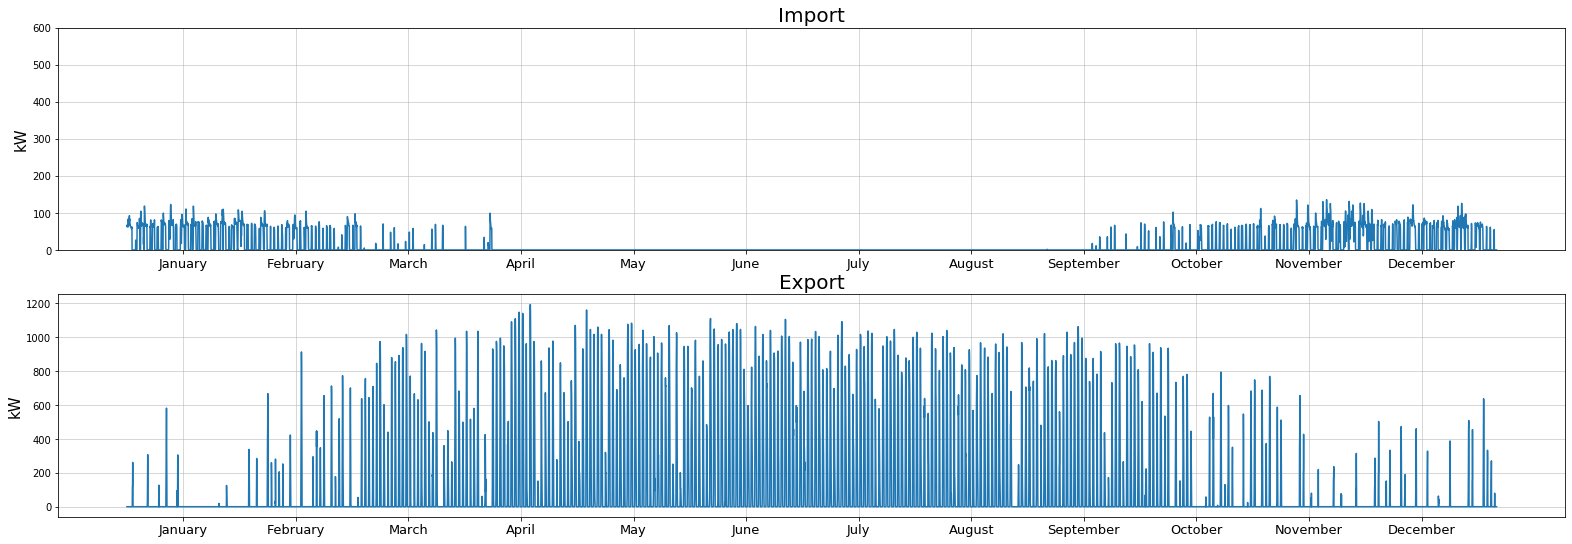

In [13]:
fig, ax = plt.subplots(2, figsize=[27,9])

ax[0].plot(_import_)
ax[0].set_title('Import',fontsize=20)
ax[0].set_ylim(0, 600)
ax[0].set_ylabel('kW',fontsize=15)
ax[0].set_xticks([d for d in range(15*24,365*24,30*24)])
ax[0].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'],fontsize=13)
ax[0].grid(lw=0.5)

ax[1].plot(_export_)
ax[1].set_title('Export',fontsize=20)
ax[1].set_ylabel('kW',fontsize=15)
ax[1].set_xticks([d for d in range(15*24,365*24,30*24)])
ax[1].set_xticklabels(['January','February','March','April','May','June','July','August','September','October','November','December'],fontsize=13)
ax[1].grid(lw=0.5)

In [14]:
# importing = pd.DataFrame(_import_)
# exporting = pd.DataFrame(_export_)
# exporting.to_csv('Export_vector.csv')
# importing.to_csv('Import_vector.csv')
# importing.to_csv('presentation2.csv')